# OCEL-mHealth to OCEL Backward Compatibility Analysis

This notebook demonstrates the backward compatibility of the OCEL-mHealth standard to the OCEL standard by analyzing what data is preserved and what is lost during conversion.

## 1. Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from src.pm4py_mHealth.covert_to_ocel import OCELmHealthToOCELConverter
from src.pm4py_mHealth.read_json import read_json

## 2. Load OCEL-mHealth Data from JSON file

In [2]:
ocel_mHealth_data_file = f"../data/transformed/player_107631_oced_data_time_bouts_notifications_stress_location.json"
ocel_mHealth_data = read_json(ocel_mHealth_data_file)

## 3. Validate OCEL-mHealth Format

In [3]:
from src.pm4py_mHealth.validation import apply

# Validate using default schema
is_valid, errors = apply("../data/transformed/player_107631_oced_data_time_bouts_notifications_stress_location.json","../schema/OCEL-mHealth.json")
is_valid

True

In [4]:
errors

[]

## 4. Convert OCEL-mHealth data to OCEL data

In [5]:
converter =  OCELmHealthToOCELConverter(ocel_mHealth_data)
ocel_data = converter.convert()
converter.save_to_file("../data/ocel/ocel_data.jsonocel")

## 5. OCEL Format Validation 


In [6]:
from pm4py.objects.ocel.validation import jsonocel
validation_result = jsonocel.apply("../data/ocel/ocel_data.jsonocel", "../schema/OCEL-2.0-Standard.json")
print(validation_result)

True


## 6. Data Loss Analysis
### 6.1 Sensor Event Analysis


In [7]:
# Analyze sensor event types and their relationships
sensor_event_types = set(event['sensorEventType'] for event in converter.ocel_mHealth_data['sensorEvents'])
sensor_relationships = []

for event in converter.ocel_mHealth_data['sensorEvents']:
    if 'relationships' in event:
        for rel in event['relationships']:
            sensor_relationships.append({
                'event_type': event['sensorEventType'],
                'related_type': rel['type'],
                'qualifier': rel['qualifier']
            })

sensor_df = pd.DataFrame(sensor_relationships)
print("Sensor Event Relationship Types:")
print(sensor_df.groupby(['event_type', 'related_type']).size().unstack(fill_value=0))

Sensor Event Relationship Types:
related_type     object
event_type             
accelerometer  15543986
activity_type      7146
heartrate       2866438
location          25806


### 6.2 Attribute Value Analysis

In [8]:
# Compare attribute value types before and after conversion
def analyze_attribute_types(data, prefix):
    types = []
    for obj in data['objects']:
        for attr in obj.get('attributes', []):
            types.append({
                'name': attr['name'],
                'original_type': type(attr['value']).__name__,
                'converted_type': 'str'  # All values are converted to strings in OCEL
            })
    return pd.DataFrame(types)

# Analyze original data
original_types = analyze_attribute_types(converter.ocel_mHealth_data, 'original')
print("Attribute Value Type Changes:")
print(original_types.groupby('original_type').size())

Attribute Value Type Changes:
original_type
float      76
int        14
str      1584
dtype: int64


## 6. Visualization of Data Loss

### 6.1 Event Type Distribution

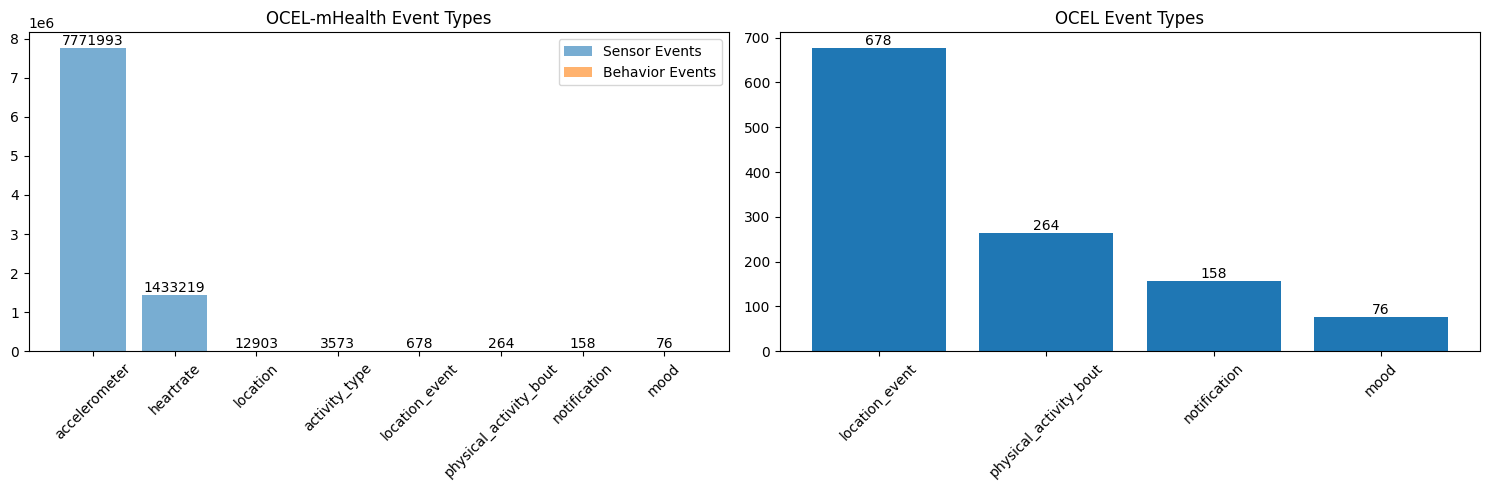

In [9]:
# Create visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Original event types
sensor_types = pd.Series([e['sensorEventType'] for e in converter.ocel_mHealth_data['sensorEvents']]).value_counts()
behavior_types = pd.Series([e['behaviorEventType'] for e in converter.ocel_mHealth_data['behaviorEvents']]).value_counts()

# Plot sensor events
bars1 = ax1.bar(sensor_types.index, sensor_types.values, label='Sensor Events', alpha=0.6)
# Add count numbers on top of sensor event bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom')

# Plot behavior events
bars2 = ax1.bar(behavior_types.index, behavior_types.values, label='Behavior Events', alpha=0.6)
# Add count numbers on top of behavior event bars
for bar in bars2:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom')

ax1.set_title('OCEL-mHealth Event Types')
ax1.legend()
ax1.tick_params(axis='x', rotation=45)

# Converted event types
ocel_types = pd.Series([e['type'] for e in ocel_data['events']]).value_counts()
bars3 = ax2.bar(ocel_types.index, ocel_types.values)
# Add count numbers on top of OCEL event bars
for bar in bars3:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom')

ax2.set_title('OCEL Event Types')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 7. Key Takeaways

1. **Data Loss**:
   - All sensor events and their relationships are dropped
   - Numeric attribute values are converted to strings
   - Sensor event relationships to behavior events are lost

2. **Preserved Data**:
   - All behavior events are maintained
   - All objects and their attributes are preserved
   - Object relationships are maintained
   - Temporal information is preserved

3. **Implications**:
   - OCEL-mHealth provides richer data for sensor-based analysis
   - OCEL compatibility ensures existing process mining tools can be used
   - The conversion is lossless for behavior events and objects